In [1]:
import datetime as dt
from math import factorial
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

metrics_path = '../metrics/'
figure_path = 'figures/'

def get_filenames_in_folder(path):
    file_names = [join(path, f) for f in listdir(path) if isfile(join(path, f)) and f.lower().endswith('.csv')]
    file_names.sort()
    return file_names

all_files = get_filenames_in_folder(metrics_path)
print(all_files)

def read_file(path):
    return pd.read_csv(path, comment='#')

if len(all_files) > 0:
    latest_data = read_file(all_files[0])
    print(latest_data.iloc[1])

plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 14,
    'figure.titlesize': 16,
    'axes.axisbelow': True
})

FIGURE_SIZE = (10, 3.125)

LINE_STYLE = {
    "linewidth": 1.5,
    "linestyle": "-"  # solid lines
}

GRID_STYLE = {
    "visible": True,
    "linestyle": "--",
    "alpha": 0.6
}

dark_blue = "#003366"
wine_red = "#800000"
dark_green = "#006400"

['../metrics/2025-07-31_10-12-42_metrics.csv', '../metrics/2025-08-04_13-15-09_metrics.csv', '../metrics/2025-08-04_16-11-57_metrics.csv', '../metrics/2025-08-04_16-14-45_metrics.csv', '../metrics/2025-08-04_16-15-33_metrics.csv', '../metrics/2025-08-04_16-17-37_metrics.csv', '../metrics/exit_join_node.csv', '../metrics/exit_join_node_save.csv']
timestamp    2025-07-31T10:08:36+00:00
field                   fragments_sent
value                              0.0
node                            node_0
Name: 1, dtype: object


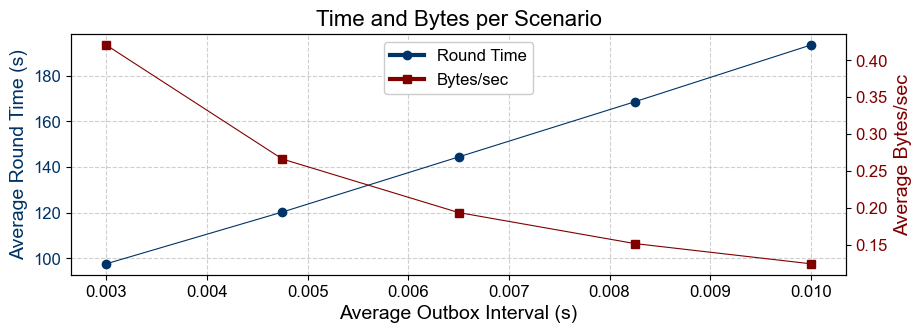

In [2]:
# Time per scenario
# 10 rounds
# y: time per whole scenario
# x: delay in seconds

mus = np.linspace(0.003, 0.01, num=5)

rt_files = get_filenames_in_folder(join(metrics_path, "run_time"))

def deserizalize_time(str_time):
    return dt.datetime.fromisoformat(str_time)

def get_duration(df):
    filtered_df = df.loc[df['field'] == "round_time"]
    return filtered_df['value'].max()

def get_total_msgbytes(df):
    return df[df['field'] == "total_mbytes_sent"].groupby('node')['value'].max().mean()

df_rt_files = [read_file(f) for f in rt_files]
rt_list = [get_duration(df) for df in df_rt_files]
bytes_list = np.array([get_total_msgbytes(df) for df in df_rt_files])

bytes_s = bytes_list / rt_list

fields = ["Round Time", "Bytes/sec"]

fig, ax1 = plt.subplots(figsize=FIGURE_SIZE)

ax1.set_title("Time and Bytes per Scenario")

# First y-axis: Scenario time
ax1.plot(mus[:len(rt_list)], rt_list, marker='o', color=dark_blue, label='Round Time', linewidth=0.8)
ax1.set_xlabel("Average Outbox Interval (s)")
ax1.set_ylabel("Average Round Time (s)", color=dark_blue)
ax1.tick_params(axis='y', labelcolor=dark_blue)

# Second y-axis: Bytes per second
ax2 = ax1.twinx()
ax2.plot(mus[:len(bytes_s)], bytes_s, marker='s', color=wine_red, label='Bytes/sec', linewidth=0.8)
ax2.set_ylabel("Average Bytes/sec", color=wine_red)
ax2.tick_params(axis='y', labelcolor=wine_red)

ax1.grid(True, linestyle='--', alpha=0.6)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
legend = ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', edgecolor=None, fontsize=12)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 1))

for line in legend.get_lines():
    line.set_linewidth(3.0)

# Save and show
plt.savefig(join(figure_path, "time-and-bytes-per-scenario.pdf"), bbox_inches="tight", dpi=600)
plt.show()


In [3]:
# CPU utilization per state (training, waiting, aggregating, broadcasting)
# y: Total CPU time per stage
# x:
#   - number of nodes
#   - number of hops

nr_nodes    = [2, 4, 6, 8, 10, 12]
nr_hops     = [1, 2, 3, 4]
outbox_size = [10 + (i) * 30 for i in range(6)]
print(outbox_size)

stages = {
    1: {"name": "Training", "color": dark_blue},
    3: {"name": "Broadcasting and Receiving", "color": wine_red}
}

def add_stage_column(df):
    df['stage'] = df.apply(lambda row: row['value'] if row['field'] == 'stage' else None, axis=1)
    df = df.sort_values(['node', 'timestamp'])
    df['stage'] = df.groupby('node')['stage'].ffill()
    df = df[df['stage'].isin(stages.keys())]
    return df.sort_values('timestamp')

def get_attr_per_stage(df, attr):
    per_stage_per_node = (
        df[df['field'] == attr]
        .groupby(['stage', 'node'])['value']
        .max()
        .reset_index()
    )

    per_stage_mean = per_stage_per_node.groupby('stage')['value'].mean()

    return per_stage_mean

def stage_plot(x_axis, x_name, folder, attr, y_name):
    files = get_filenames_in_folder(join(metrics_path, folder))[:len(x_axis)]
    df_files = [add_stage_column(read_file(f)) for f in files]

    y_axis = [get_attr_per_stage(df, attr) for df in df_files]
    data = np.array(y_axis)

    x = np.arange(len(x_axis))
    width = 0.2

    fig, ax = plt.subplots(figsize=FIGURE_SIZE)

    vmin = np.inf
    vmax = -np.inf
    lines_plotted = False

    for i, stage in enumerate(stages):
        bar = ax.bar(
            x + i * width,
            data[:, i],
            width=width,
            label=stages[stage]["name"],
            color=stages[stage]["color"]
        )
        for rect in bar:
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_y() + height * 0.80,
                f'{height:.1f}',
                ha='center',
                va='center',
                color='white',
                rotation=90
            )
        lines_plotted = True
        vmin = min(vmin, data[:, i].min())
        vmax = max(vmax, data[:, i].max())

    if not lines_plotted:
        plt.close(fig)
        return

    ax.set_xticks(x + width / 2)
    ax.set_xticklabels(x_axis)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_title(f"{y_name} per Stage and {x_name}")
    ax.grid(True, linestyle='--', alpha=0.6)

    legend = ax.legend(
        title='Stage',
        loc='upper center',
        bbox_to_anchor=(0.5, -0.25),
        edgecolor=None,
        fontsize=12,
        ncol=len(stages)
    )
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((1, 1, 1, 1))
    for line in legend.get_lines():
        line.set_linewidth(3.0)


    if np.isfinite(vmin) and np.isfinite(vmax) and vmin >= 0 and vmax <= 1:
        ax.set_ylim(0, 1)
        ax.set_yticks(np.linspace(0, 1, 10))

    plt.savefig(join(figure_path, f"{'_'.join(y_name.lower().split())}_per_stage_{folder}.pdf"), bbox_inches="tight", dpi=600)
    plt.show()


[10, 40, 70, 100, 130, 160]


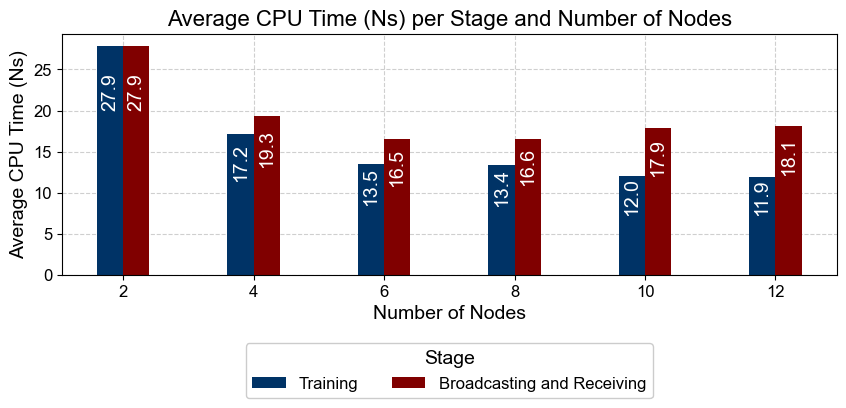

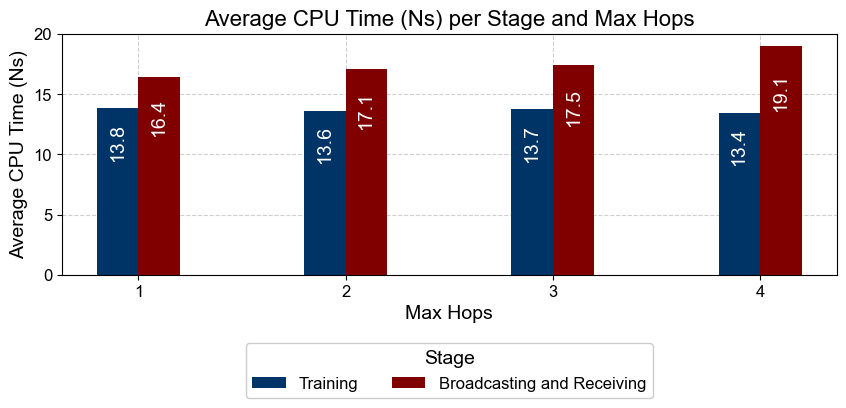

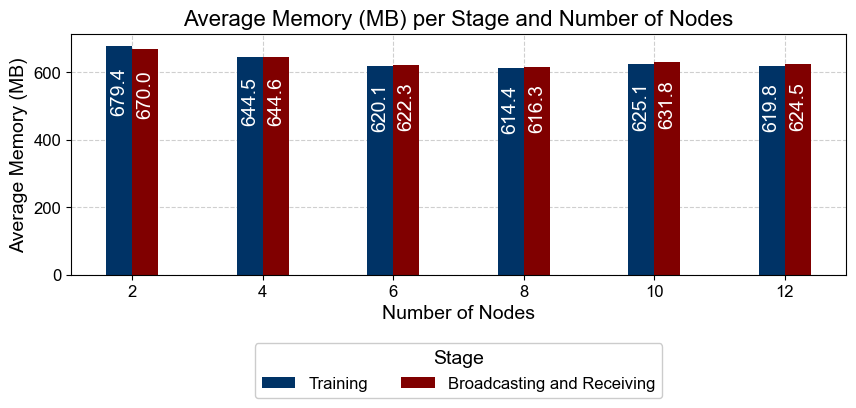

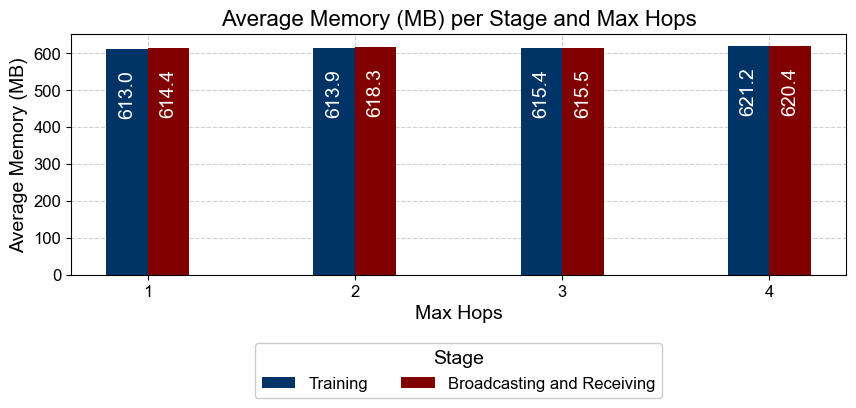

In [4]:
stage_plot(nr_nodes, "Number of Nodes", "nr_nodes", "cpu_total_ns", "Average CPU Time (Ns)")
stage_plot(nr_hops[:4], "Max Hops", "max_hops", "cpu_total_ns", "Average CPU Time (Ns)")
stage_plot(nr_nodes, "Number of Nodes", "nr_nodes", "memory_mb", "Average Memory (MB)")
stage_plot(nr_hops[:4], "Max Hops", "max_hops", "memory_mb", "Average Memory (MB)")

In [5]:
# y: RTT
# x:
#   - delay in seconds
#   - number of hops


def get_avg_rtt(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')

    # max_peers = df[df['field'] == "active_peers"]["value"].max()
    # start, end = get_time_interval(df, "active_peers", max_peers)

    # df_interval = df[(df['timestamp'] > start) & (df['timestamp'] < end)]
    # df_interval = df
    rtt_per_node = df[(df['field'] == "last_rtt") & (df['value'] != 0)].groupby('node')
    mean_per_node = rtt_per_node['value'].apply(lambda x: x.unique().mean())
    mean = mean_per_node.mean()
    return mean

In [6]:
def plot_combined_rtt_and_bytes_subplots(x_sets, x_labels, folders, image_prefix):
    # Create 1 row with 3 columns for RTT
    fig_rtt, axs_rtt = plt.subplots(1, 3, figsize=FIGURE_SIZE, sharey=True)
    fig_bytes, axs_bytes = plt.subplots(1, 3, figsize=FIGURE_SIZE, sharey=True)
    fig_total_bytes, axs_total_bytes = plt.subplots(1, 3, figsize=FIGURE_SIZE, sharey=True)

    markers = ['o', 's', '^']
    colors = [dark_blue, wine_red, dark_green]

    for i, (x_vals, xlabel, folder) in enumerate(zip(x_sets, x_labels, folders)):
        files = get_filenames_in_folder(join(metrics_path, folder))
        df_files = [read_file(f) for f in files]

        y_rtt = [get_avg_rtt(df) for df in df_files]
        rt_list = [get_duration(df) for df in df_files]
        y_total_bytes = np.array([get_total_msgbytes(df) for df in df_files])
        y_bytes_s = y_total_bytes / rt_list

        # Ensure all y values match x_vals in length
        n = min(len(df_files), len(x_vals))
        x_vals = x_vals[:n]
        y_rtt = y_rtt[:n]
        y_bytes_s = y_bytes_s[:n]
        y_total_bytes = y_total_bytes[:n]

        # RTT subplot
        axs_rtt[i].plot(x_vals, y_rtt, marker=markers[i], color=colors[i], linewidth=0.8)
        axs_rtt[i].set_title(xlabel)
        axs_rtt[i].set_xlabel(xlabel)
        if i == 0:
            axs_rtt[i].set_ylabel("Average RTT (s)")
        axs_rtt[i].grid(True, linestyle='--', alpha=0.6)
        legend_rtt = axs_rtt[i].legend(["RTT"], loc="upper center", edgecolor=None, fontsize=12)
        legend_rtt.get_frame().set_alpha(None)
        legend_rtt.get_frame().set_facecolor((1, 1, 1, 1))
        for line in legend_rtt.get_lines():
            line.set_linewidth(3.0)

        # Bytes/sec subplot
        axs_bytes[i].plot(x_vals, y_bytes_s, marker=markers[i], color=colors[i], linewidth=0.8)
        axs_bytes[i].set_title(xlabel)
        axs_bytes[i].set_xlabel(xlabel)
        if i == 0:
            axs_bytes[i].set_ylabel("Average Output (Bytes/sec)")
        axs_bytes[i].grid(True, linestyle='--', alpha=0.6)
        legend_bytes = axs_bytes[i].legend(["Bytes/sec"], loc="upper center", edgecolor=None, fontsize=12)
        legend_bytes.get_frame().set_alpha(None)
        legend_bytes.get_frame().set_facecolor((1, 1, 1, 1))
        for line in legend_bytes.get_lines():
            line.set_linewidth(3.0)

        # Total bytes subplot
        axs_total_bytes[i].plot(x_vals, y_total_bytes, marker=markers[i], color=colors[i], linewidth=0.8)
        axs_total_bytes[i].set_title(xlabel)
        axs_total_bytes[i].set_xlabel(xlabel)
        if i == 0:
            axs_total_bytes[i].set_ylabel("Total Bytes Sent")
        axs_total_bytes[i].grid(True, linestyle='--', alpha=0.6)
        legend_total_bytes = axs_total_bytes[i].legend(["Total Bytes"], loc="upper center", edgecolor=None, fontsize=12)
        legend_total_bytes.get_frame().set_alpha(None)
        legend_total_bytes.get_frame().set_facecolor((1, 1, 1, 1))
        for line in legend_total_bytes.get_lines():
            line.set_linewidth(3.0)

    fig_rtt.suptitle("Average Round Trip Time (RTT)", fontsize=18)
    fig_bytes.suptitle("Average Throughput", fontsize=18)
    fig_total_bytes.suptitle("Total Bytes Sent", fontsize=18)
    fig_rtt.tight_layout(rect=[0, 0.03, 1, 1])
    fig_bytes.tight_layout(rect=[0, 0.03, 1, 1])
    fig_total_bytes.tight_layout(rect=[0, 0.03, 1, 1])
    fig_rtt.savefig(join(figure_path, f"{image_prefix}_rtt_subplots.pdf"), bbox_inches="tight", dpi=600)
    fig_bytes.savefig(join(figure_path, f"{image_prefix}_bytes_subplots.pdf"), bbox_inches="tight", dpi=600)
    fig_total_bytes.savefig(join(figure_path, f"{image_prefix}_total_bytes_subplots.pdf"), bbox_inches="tight", dpi=600)
    plt.show()


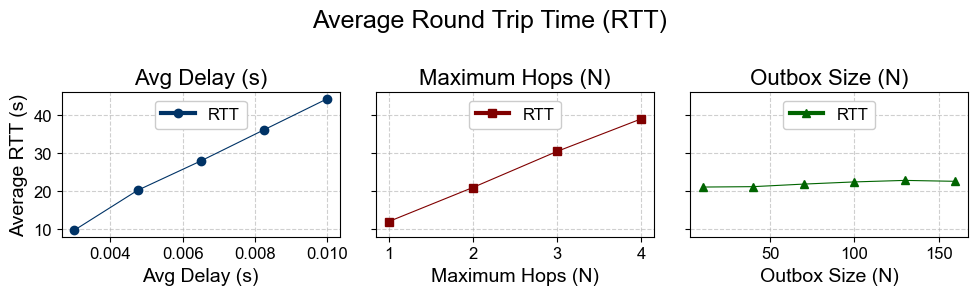

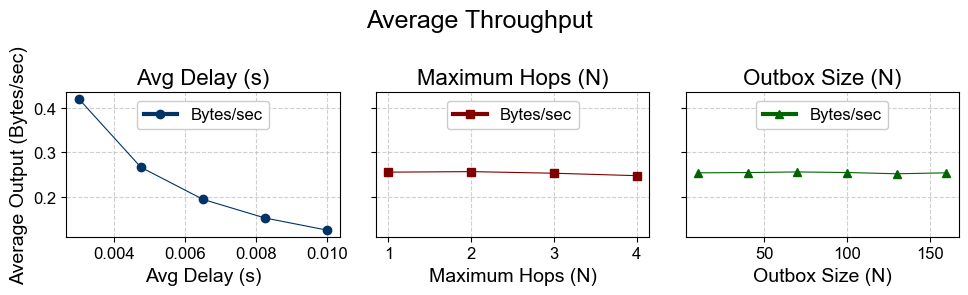

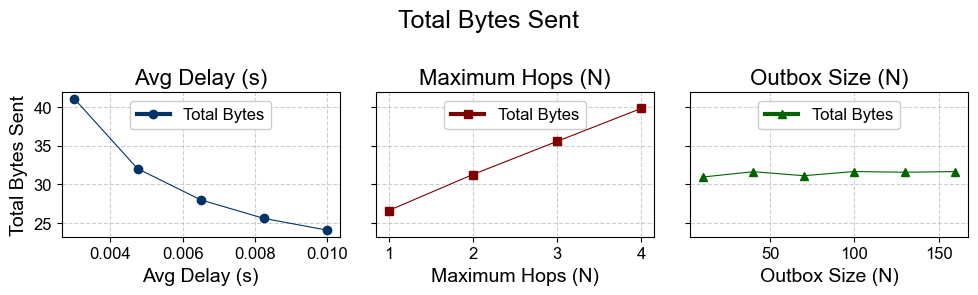

In [7]:
x_sets = [mus, nr_hops, outbox_size]
x_labels = ["Avg Delay (s)", "Maximum Hops (N)", "Outbox Size (N)"]
folders = ["run_time", "max_hops", "outbox_size"]

plot_combined_rtt_and_bytes_subplots(x_sets, x_labels, folders, "combined_metrics")

The output rate of a node is solely determined by the average output rate parameter, therefore the curve is completely flat for max hops and otubox size

Therefore, total bytes increase with maximum hops and it decreases all the same with avg outbox interval, bc it controls the amount of cover traffic.

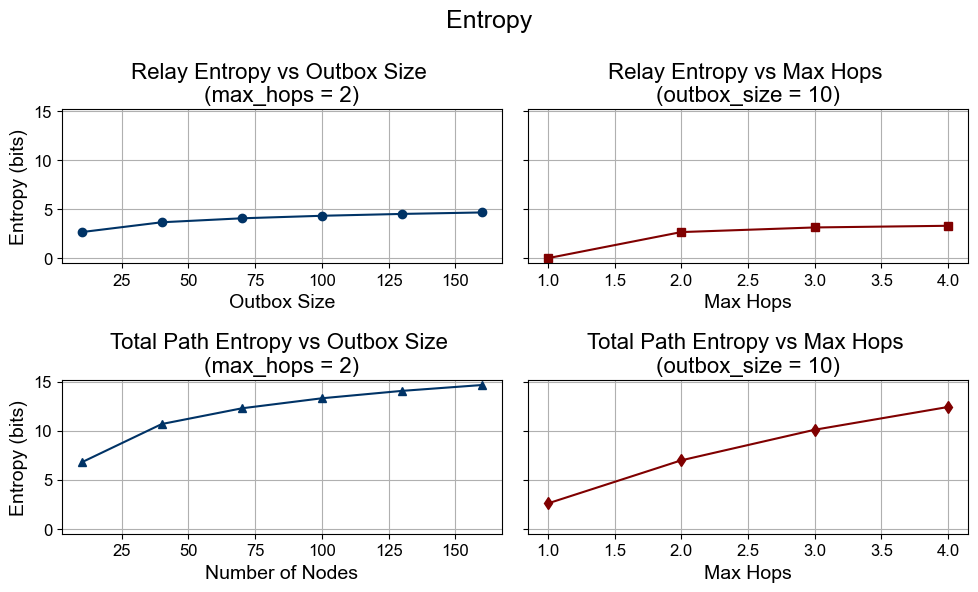

In [8]:
def entropy(probs):
    sum = 0
    for p in probs:
        sum += p * np.log2(p)
    return -sum

# the entropy of matching incoming message to outgoing message in a singular node
def entropy_in_out(outbox_size, max_hops):
    terminated = 1/max_hops
    relayed = 1 - terminated
    relayed_events = [relayed * 1/outbox_size] * outbox_size if relayed != 0 else []
    events = relayed_events + [terminated]
    return entropy(events)

# X e nodes - start node
# tracking a fragment to its recipient
def entropy_recipient(max_hops, nr_nodes):
    n_events = 0
    for hops in range(1, max_hops+1):
        n_per_hops = int(factorial(nr_nodes-1)/factorial(nr_nodes-1-max_hops))
        n_events += n_per_hops
    probs = [1/n_events] * n_events
    return entropy(probs)

def total_path_entropy(outbox_size, max_hops):
    n_events = 0
    for hops in range(1, max_hops+1):
        n_events += outbox_size**hops
    probs = [1/n_events] * n_events
    return entropy(probs)

y_e_io_outbox   = [entropy_in_out(outbox, 2) for outbox in outbox_size]
y_e_io_hops     = [entropy_in_out(10, hops) for hops in nr_hops]
y_e_total_hops    = [total_path_entropy(outbox, 2) for outbox in outbox_size]
y_e_total_nodes   = [total_path_entropy(hops, 6) for hops in nr_hops]

all_vals = y_e_io_outbox + y_e_io_hops + y_e_total_hops + y_e_total_nodes
max_y = max(all_vals) + 0.5
min_y = min(all_vals) - 0.5

fig, axs = plt.subplots(2, 2, figsize=(10, 6.25))
axs = axs.flatten()  # makes indexing easier (axs[0] to axs[3])

# Plot 1: entropy_path vs outbox_size (max_hops = 2)
axs[0].plot(outbox_size, y_e_io_outbox, marker='o', color=dark_blue)
axs[0].set_title("Relay Entropy vs Outbox Size \n(max_hops = 2)")
axs[0].set_xlabel("Outbox Size")
axs[0].set_ylabel("Entropy (bits)")
axs[0].grid(True)
axs[0].set_ylim(min_y, max_y)

# Plot 2: entropy_path vs max_hops (outbox_size = 10)
axs[1].plot(nr_hops, y_e_io_hops, marker='s', color=wine_red)
axs[1].set_title("Relay Entropy vs Max Hops \n(outbox_size = 10)")
axs[1].set_xlabel("Max Hops")
axs[1].set_ylabel("")
axs[1].set_yticklabels([])
axs[1].grid(True)
axs[1].set_ylim(min_y, max_y)

# Plot 3: entropy_recipient vs nr_nodes (max_hops = 2)
axs[2].plot(outbox_size, y_e_total_hops, marker='^', color=dark_blue)
axs[2].set_title("Total Path Entropy vs Outbox Size \n(max_hops = 2)")
axs[2].set_xlabel("Number of Nodes")
axs[2].set_ylabel("Entropy (bits)")
axs[2].grid(True)
axs[2].set_ylim(min_y, max_y)

# Plot 4: entropy_recipient vs max_hops (nr_nodes = 6)
axs[3].plot(nr_hops, y_e_total_nodes, marker='d', color=wine_red)
axs[3].set_title("Total Path Entropy vs Max Hops \n(outbox_size = 10)")
axs[3].set_xlabel("Max Hops")
axs[3].set_yticklabels([])
axs[3].set_ylabel("")
axs[3].grid(True)
axs[3].set_ylim(min_y, max_y)

# Adjust layout and save
fig.suptitle("Entropy", fontsize=18)
fig.tight_layout(rect=[0, 0.03, 1, 1])
fig.savefig(join(figure_path, "entropy_combined_subplots.pdf"), bbox_inches="tight", dpi=600)
plt.show()


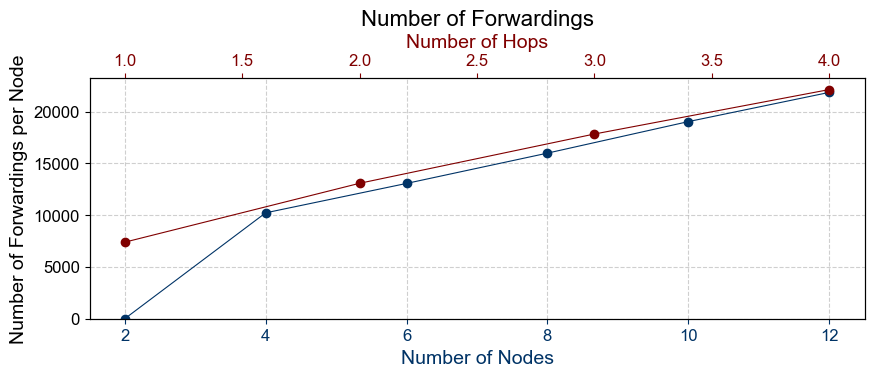

In [9]:
def get_nr_forwardings(df):
    max_mean = df[df["field"] == "forwarded"].groupby("node")['value'].max().mean()
    return max_mean

def get_y_axis_values(folder):
    files = get_filenames_in_folder(join(metrics_path, folder))
    df_files = [read_file(f) for f in files]
    return [get_nr_forwardings(df) for df in df_files]

def plot_avg_forwardings(x_axis, y_axis, ax, xlabel, color):
    n = min(len(x_axis), len(y_axis))
    x_axis, y_axis = x_axis[:n], y_axis[:n]
    ax.plot(x_axis, y_axis, marker='o', color=color, label=xlabel, linewidth=0.8)
    ax.set_xlabel(xlabel, color=color)
    ax.set_ylabel("Number of Forwardings per Node")
    ax.tick_params(axis='x', colors=color)

y_nodes = get_y_axis_values("nr_nodes")
y_hops = get_y_axis_values("max_hops")

fig, ax1 = plt.subplots(figsize=FIGURE_SIZE)

plot_avg_forwardings(nr_nodes, y_nodes, ax1, "Number of Nodes", color=dark_blue)
ax1.set_ylabel("Number of Forwardings per Node")
ax1.set_ylim(bottom=0, top=max(max(y_nodes), max(y_hops)) * 1.05)

ax2 = ax1.twiny()
plot_avg_forwardings(nr_hops[:4], y_hops, ax2, "Number of Hops", color=wine_red)

ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_title("Number of Forwardings")

plt.savefig(join(figure_path, "nr_forwardings.pdf"), bbox_inches="tight", dpi=600)
plt.show()


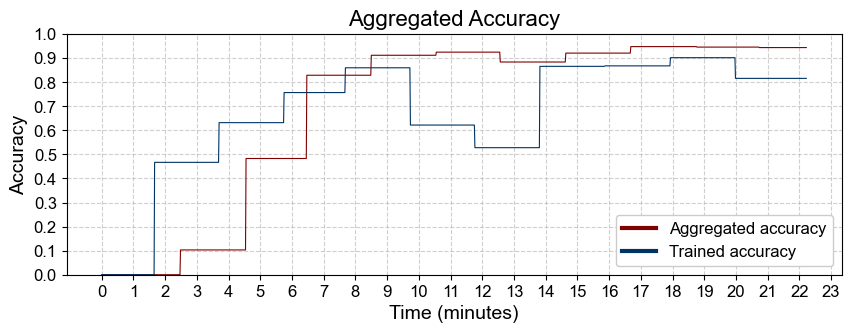

In [10]:
def plot_acc(node):
    filename = get_filenames_in_folder(join(metrics_path, "accuracy"))[2]
    df = read_file(filename)
    timestamps = df[(df['node'] == node) & (df['field'] == 'aggregated_accuracy')]['timestamp']

    timestamps = pd.to_datetime(timestamps)
    x_axis = (timestamps - timestamps.min()).dt.total_seconds()
    agg_acc = df[(df['node'] == node) & (df['field'] == 'aggregated_accuracy')]['value']

    acc = df[(df['node'] == node) & (df['field'] == 'accuracy')]['value']
    fig, ax = plt.subplots(figsize=FIGURE_SIZE)

    ax.plot(x_axis / 60, agg_acc, color=wine_red, label="Aggregated accuracy", linewidth=0.8)
    ax.plot(x_axis / 60, acc, color=dark_blue, label="Trained accuracy", linewidth=0.8)

    lines_plotted = True

    if not lines_plotted:
        plt.close(fig)
        return

    ax.set_title("Aggregated Accuracy")
    ax.set_xlabel("Time (minutes)")
    ax.set_ylabel("Accuracy")
    ax.grid(True, linestyle='--', alpha=0.6)

    legend = ax.legend(loc="lower right", edgecolor=None, fontsize=12)
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor((1, 1, 1, 1))
    for line in legend.get_lines():
        line.set_linewidth(3.0)

    x_tick_interval = 1
    max_x = x_axis.max() / 60
    ax.set_xticks(np.arange(0, max_x + x_tick_interval, x_tick_interval))

    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1.1, 0.1))

    plt.savefig(join(figure_path, "agg_accuracy.pdf"), bbox_inches="tight", dpi=600)
    plt.show()

plot_acc('node_0')

<Figure size 1000x312.5 with 0 Axes>

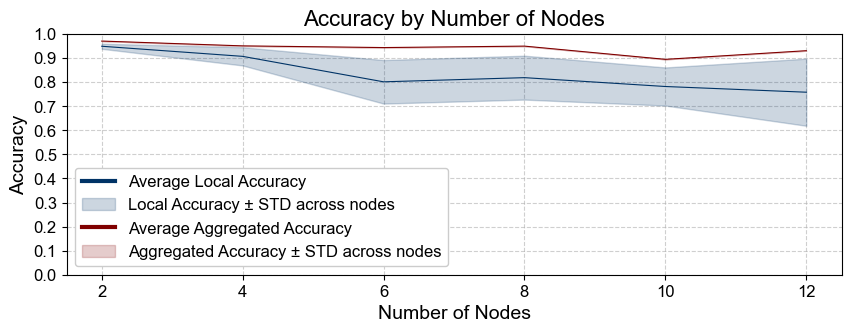

In [11]:
plt.figure(figsize=FIGURE_SIZE)

files = get_filenames_in_folder(join(metrics_path, "accuracy"))

dfs = [read_file(f) for f in files]

def get_attr_per_node(df, attr):
    return df[df['field'] == attr].groupby('node').tail(1)['value']

local_mean = np.array([get_attr_per_node(df, 'accuracy').mean() for df in dfs])
local_std = np.array([get_attr_per_node(df, 'accuracy').std() for df in dfs])
global_mean = np.array([get_attr_per_node(df, 'aggregated_accuracy').mean() for df in dfs])
global_std = np.array([get_attr_per_node(df, 'aggregated_accuracy').std() for df in dfs])

fig, ax = plt.subplots(figsize=FIGURE_SIZE)

ax.plot(nr_nodes, local_mean, color=dark_blue, label="Average Local Accuracy", linewidth=0.8)
ax.fill_between(
    nr_nodes,
    local_mean - local_std,
    local_mean + local_std,
    color=dark_blue,
    alpha=0.2,
    label="Local Accuracy ± STD across nodes"
)
ax.plot(nr_nodes, global_mean, color=wine_red, label="Average Aggregated Accuracy", linewidth=0.8)
ax.fill_between(
    nr_nodes,
    global_mean - global_std,
    global_mean + global_std,
    color=wine_red,
    alpha=0.2,
    label="Aggregated Accuracy ± STD across nodes"
)

ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylabel("Accuracy", fontsize=14)
ax.set_xlabel("Number of Nodes", fontsize=14)
ax.set_title("Accuracy by Number of Nodes", fontsize=16)

ax.grid(True, linestyle='--', alpha=0.6)

legend = ax.legend(fontsize=12, loc="lower left", edgecolor=None)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1, 1, 1, 1))
for line in legend.get_lines():
    line.set_linewidth(3.0)

plt.savefig(join(figure_path, "accuracy_by_nodes.pdf"), bbox_inches="tight", dpi=600)
plt.show()
